# LSTM - bert128

- **Training set**: LO_SARD102
- **Test/Validation set:** JTT
- **Features**: bert sequence (64)
- **Class imbalance processing**: SMOTE

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def oversample_smote(X, y):
    from imblearn.over_sampling import SMOTE
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output before SMOTE:", counter)
    
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output after SMOTE:", counter)
    return X, y


X_train = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_X.npy')
Y_train = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_y.h5').is_vulnerable.values

X_test = numpy.load('/mnt/md0/user/scheuererra68323/JTT_bert64_X.npy')
Y_test = pd.read_hdf('/mnt/md0/user/scheuererra68323/JTT_bert64_y.h5').is_vulnerable.values

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, stratify=Y_train, test_size=0.2, random_state=10
)

# oversample class 1
X_train, Y_train = oversample_smote(np.reshape(X_train, (-1, 64*768)), Y_train )
X_train = np.reshape( X_train, (-1, 64, 768) )

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

Counter output before SMOTE: Counter({0: 15656, 1: 308})
Counter output after SMOTE: Counter({0: 15656, 1: 15656})
(31312, 64, 768)
(31312,)
(3991, 64, 768)
(3991,)
(5607, 64, 768)
(5607,)


## Variant 1

In [4]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    model = keras.Sequential()
    model.add(layers.LSTM(512, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add( layers.TimeDistributed(layers.Dense(256)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=512,
                        epochs=8,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


model, history = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64, 512)           2623488   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 256)           131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5578
           1       0.00      0.00      0.00        29

    accuracy                           0.99      5607
   macro avg       0.50      0.50      0.50      5607
weighted avg       0.99      0.99      0.99      5607

Confusion matrix:
[[5578    0]
 [  29    0]]

Confusion matrix (Percentages):
[[99.483  0.   ]
 [ 0.517  0.   ]]

Metrics:
Sensitivity (TPR): 0.000000
Specifity (TNR):   1.000000

FPR: 0.000000
FNR: 1.000000

Balanced accuracy: 0.500000

Test loss:	0.092521
Test accuracy:	0.994828


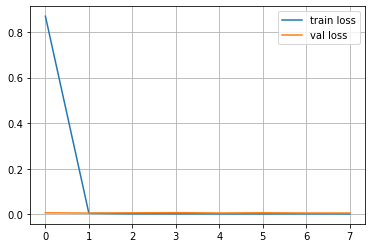

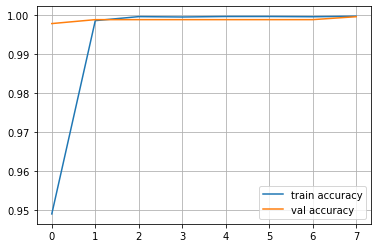

In [5]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [6]:
model.save('testJTT_LSTM_bert64_SMOTE_Var1.h5')

## Variant 2

In [7]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):    
    model = keras.Sequential()
    model.add(layers.LSTM(256, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add( layers.TimeDistributed(layers.Dense(256)) )
    model.add( layers.TimeDistributed(layers.Dense(128)) )
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=1024,
                        epochs=4,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


modelv2, historyv2 = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64, 256)           1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 64, 256)           65792     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 64, 128)           32896     
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5578
           1       0.00      0.00      0.00        29

    accuracy                           0.99      5607
   macro avg       0.50      0.50      0.50      5607
weighted avg       0.99      0.99      0.99      5607

Confusion matrix:
[[5578    0]
 [  29    0]]

Confusion matrix (Percentages):
[[99.483  0.   ]
 [ 0.517  0.   ]]

Metrics:
Sensitivity (TPR): 0.000000
Specifity (TNR):   1.000000

FPR: 0.000000
FNR: 1.000000

Balanced accuracy: 0.500000

Test loss:	0.059540
Test accuracy:	0.994828


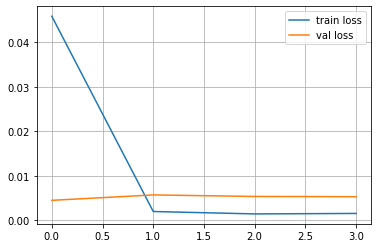

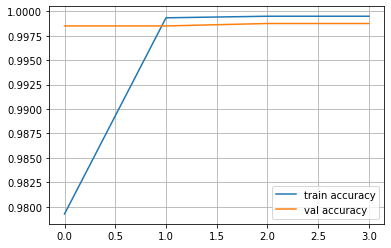

In [8]:
evaluate_classifier(modelv2, historyv2)

In [9]:
modelv2.save('testJTT_LSTM_bert64_SMOTE_Var2.h5')